# Approximate Nearest Neighbours Search. Tree indices

Today's lab is devoted to ANNS with trees. At the lecture we discussed that trees can be very useful, if we have vector representation of an object. Today you will write your our own index (simple kd-tree) and compare it with [Annoy](https://github.com/spotify/annoy) library.

Tutorial consists of the following parts:
1. Writing kd-tree
  1. building kd-tree index
  2. implementing kd-tree search
  3. implementing KNN search
  4. implementing kd-tree insertion
2. Building Annoy index (`pip install --user annoy`)
3. Practicing on real data (download a dataset from [here](https://drive.google.com/drive/folders/1nhiJC6g5R5uPDYwa-6sz9_bJ3sYGm8mM?usp=sharing))
  1. KNN search on real data
  2. implementing kd-tree range search
4. Bonus Task. Set of open questions

In [0]:
# all necessary imports are here
import random, time, sys
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import pickle

# Data Generation
Firstly you will test your data structure using randomly generated values. At this step generate big enough random dataset. If your laptop spends a lot of time on this operation, please, reduce `maxsize` value and rerun.

After you finish implementation, you can tune `K_random` parameter to see how the number of dimensions influences data structure time complexity (see question 4).

In [2]:
K_random = 3
maxsize = 50000
start = time.time()
R = np.random.rand(maxsize, K_random)
R = [(row, "stub value {}".format(i)) for i, row in enumerate(R)]
print(R[:3])
finish = time.time()
print("{} rows generated in {:.2f} s".format(len(R), finish - start))

[(array([0.98459523, 0.45224201, 0.8045975 ]), 'stub value 0'), (array([0.7161094 , 0.4511443 , 0.68819303]), 'stub value 1'), (array([0.19598424, 0.48856068, 0.46364563]), 'stub value 2')]
50000 rows generated in 0.05 s


# 1. Implementations
Within this cell you will iteratively implement major methods of [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) data structure. Biggest part of code is already written - just fill remaining gaps. 

This particular implementation is designed to be **non-homogeneous**, which means it **stores values only in leaf nodes**. But this doesn't limit you if you want to implement other approach.

Each leaf node can hold up to `leaf_capacity` items.

Item stored in an index is a tuple: `(coordinate_k_dim_vector, value)`.

Search requires only `coordinate_k_dim_vector` and returns relevant item(s).

In [0]:
class Node:
    def __init__(self, K=None, parent=None):
        assert K is not None or parent, "Either `K` should be provided for root node, or `parent` for internal nodes"
        # Reference to parent node. Used in ANNS search
        self.parent = parent
        # depth start from 0. To compute dimension, relevant to the level, use (self.depth % self.K)
        self.depth = (parent.depth + 1) if parent else 0
        # K means number of vector dimensions
        self.K = parent.K if parent else K
        # value, which splits subspace into to parts using hyperplane: item[self.depth % self.K] == self.pivot
        # pivot is empty for any leaf node.
        self.pivot = None
        # left and right child nodes
        self.left = None
        self.right = None
        # collection of items
        self.items = None
        
    def build_kd_tree(self, items, leaf_capacity=4):
        '''Takes a list of items and arranges it in a kd-tree'''
        assert items is not None, "Please provide at least one point"
        # put all items in the node if they fit into limit
        axis = self.depth % self.K
        if len(items) <= leaf_capacity or len(np.unique([item[0] for item in items]))==1: # OR ALL ELEMENTS ARE SAME
            self.items = items
        # or else split items into 2 subnodes using median value
        else:
            self.items = None
            self.left = Node(parent=self)
            self.right = Node(parent=self)
            
            #TODO 1.A.: fill in the code to initialize internal node.
            # Be careful: there may be multiple items with the same values as pivot,
            # make sure they go to the same child.
            # Also, there may be duplicate items, and you need to deal with them
            # берем медиану по измерению depth%k, k размерность вектора
            sorted_items = sorted(items, key=lambda pair: pair[0][axis])
            idx = len(sorted_items)//2
            self.pivot = sorted_items[idx][0][axis]   # here you should write median value with respect to coordinate
            
            for i in range(idx,len(sorted_items)):
              if sorted_items[i][0][axis] != self.pivot:
                i-=1
                break
            left = sorted_items[:i+1]
            right = sorted_items[i+1:]

            if len(right)==0:
              for i in range(idx,0,-1):
                if sorted_items[i][0][axis] != self.pivot:
                  break
            self.pivot = sorted_items[i][0][axis]
            left = sorted_items[:i+1]
            right = sorted_items[i+1:]

            self.left.build_kd_tree(left)
            self.right.build_kd_tree(right)

        return self
    
    def kd_find_leaf(self, key):
        # key массив из х значений
        ''' returns a node where key should be stored (but can be not present)'''
        if self.pivot is None or self.items is not None: # leaf node OR empty root
            return self
        else:
            
            #TODO 1.B. This is a basic operation for travesing the tree.
            # define correct path to continue recursion 
            axis = self.depth % self.K
            value = key[axis]

            if value<=self.pivot:
              return self.left.kd_find_leaf(key)
            else:
              return self.right.kd_find_leaf(key)
            
#     def kd_insert_no_split(self, item):
#         '''Naive implementation of insert into leaf node. It is not used in tests of this tutorial.'''
#         node = self.kd_find_leaf(item[0])
#         node.items.append(item)
        
    def kd_insert_with_split(self, item, leaf_capacity=4):
      '''This method recursively splits the nodes into 2 child nodes if they overflow `leaf_capacity`'''
      # (array([0.52543181, 0.94242058, 0.75474618]), 'stub value test 1.C.')
      #TODO 1.C. This is very simple insertion procedure.
      # Split the node if it cannot accept one more item.
      # HINT: reuse kd_find_leaf() and build_kd_tree() methods if possible
      node_to_store = self.kd_find_leaf(item[0])
      if node_to_store.items is None:
        self.build_kd_tree([item], leaf_capacity)
      elif len(node_to_store.items)<leaf_capacity:
        node_to_store.items.append(item)
      else: # make items none and create right and left childs for this node
        items_to_split = node_to_store.items
        items_to_split.append(item)
        node_to_store.items = None
        node_to_store.build_kd_tree(items_to_split, leaf_capacity)

    def get_all_leaves(self):
      if self.items is not None:
        return self.items
      else:
        return self.left.get_all_leaves()+self.right.get_all_leaves()

    def get_nn(self, key, knn):
        # key массив из 3х значений
        '''Return K approximate nearest neighbours for a given key'''
        node = self.kd_find_leaf(key)
        best = []
        
        #TODO 1.D. ANN search.
        # write here the code which returns `knn` 
        # approximate nearest neighbours with respect to euclidean distance
        # basically, you need to move up through the parents chain until the number of elements
        # in a parent subtree is more or equal too the expected number of nearest neighbors,
        # and then return top-k elements of this subtree sorted by euclidean distance
        # HINT: you can use [scipy.spatial.]distance.euclidean(a, c) - it is already imported
        
        # надо найти knn штук ближайших соседей в дереве в терминах евклидова расстояния
        # 1 ходить по дереву пока не найдем всех ближайших детей
        # if there are no parent of the node or number of items the node is more than or equal to knn just return items
        if node.parent == None or len(node.items)>=knn:
          for item in node.items:
            best.append((item, distance.euclidean(item[0], key)))
        else:
          parent = node.parent
          while len(best)<knn:
            #look through all their childs and fill the best list
            best = parent.get_all_leaves()
            parent = parent.parent
        
        best = [(item, distance.euclidean(item[0], key)) for item in best ]
        best = sorted(best, key=lambda pair: pair[1])[:knn]
        return [item[0] for item in best]
    
    def get_in_range(self, lower_left_bound_key, upper_right_bound_key):
        '''Runs range query. Returns all items bounded by the given corners: `lower_left_bound_key`, `upper_right_bound_key`'''
        result = []
        if self.pivot is None or self.items is not None: # internal node OR empty root
            #TODO 3.B.: This is a leaf node. Select only those items from self.item
            # which fall into a given range
            for item in self.items:
              is_ok = True
              for i in range(len(item[0])):
                if item[0][i]<lower_left_bound_key[i] or item[0][i]>upper_right_bound_key[i]:
                  is_ok = False
              if is_ok:
                result.append(item)
            return result
        else:
            #TODO 3.B.: This is an internal node.
            # write recursive code to collect corresponding data from subtrees
            # compare pivot to the bounds to decide whether to consider any of its children for search
            axis = self.depth%self.K
            if self.pivot < lower_left_bound_key[axis]:
              return self.right.get_in_range(lower_left_bound_key, upper_right_bound_key)
            if self.pivot>upper_right_bound_key[axis]:
              return self.left.get_in_range(lower_left_bound_key, upper_right_bound_key)
            else:
              return self.right.get_in_range(lower_left_bound_key, upper_right_bound_key)+self.left.get_in_range(lower_left_bound_key, upper_right_bound_key)

### 1.A. Build procedure ###
`build_kd_tree()` method implements the core idea. This is the suggested idea, but you can modify it slightly:
- tree is non-homogenous, thus, items are stored in leaf nodes only.
- `self.pivot` should be assigned the median value for correspoinding `depth % K` coordinate.
- `left` variable should hold all the items <= than `self.pivot`.
- `right` variable should hold all the items > than `self.pivot`.
- `node_capacity=X` allows to store up to `X` items in a leaf node.

This is how it works for `K=2, node_capacity=2`:
![kd-tree](http://sprotasov.ru/files/kd.png)

Next block will generate you a graph `time(size)`. Please explore the graph. Is it close to linear function?

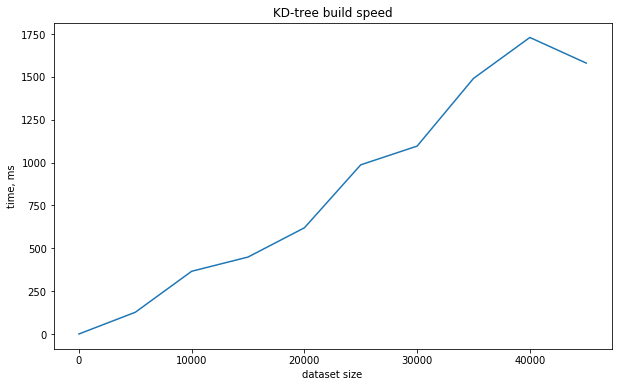

In [4]:
# sample 10, 20, ..., 100% of R
step = len(R) // 10
sizes, build_times = [], []

# tqdm_notebook draws a progress bar. If it doesnt't work in your environment, just remove it.
for size in tqdm_notebook(range(1, len(R) + 1, step)):
    sample = R[:size]
    start = time.time()
    kdtree = Node(K=K_random).build_kd_tree(sample)
    finish = time.time()
    sizes.append(size)
    build_times.append((finish - start) * 1000)

    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('time, ms')
plt.plot(sizes, build_times)
plt.title("KD-tree build speed")
plt.show()

### 1.B. Search ###
Before running this block, please complete the finction `kd_find_leaf()` which accepts a key vector and returns one leaf node, which should store this key. After you complete, you will see how fastly your queries can be processed with respect to dataset size.

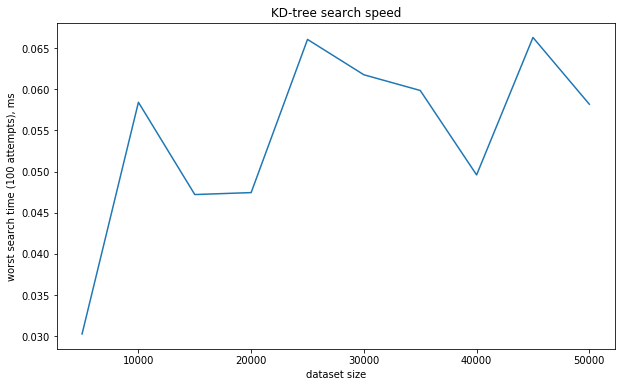

In [5]:
step = len(R) // 10
sizes, search_times = [], []

for size in tqdm_notebook(range(step, len(R) + 1, step)):
    kdtree = Node(K=K_random).build_kd_tree(R[:size])
    
    iterations = 100
    duration = None
    for i in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        start = time.time()
        kdtree.kd_find_leaf(x[0])
        finish = time.time()
        duration = max(duration, finish - start) if duration else finish - start
        
    sizes.append(size)
    search_times.append(duration * 1000)
    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('worst search time (100 attempts), ms')
plt.plot(sizes, search_times)
plt.title("KD-tree search speed")
plt.show()

### 1.C. Insertion ###
Now let's see how fast the tree depth is growing for different capacity set-ups. Implement the remaining part of `kd_insert_with_split()` and run the test.

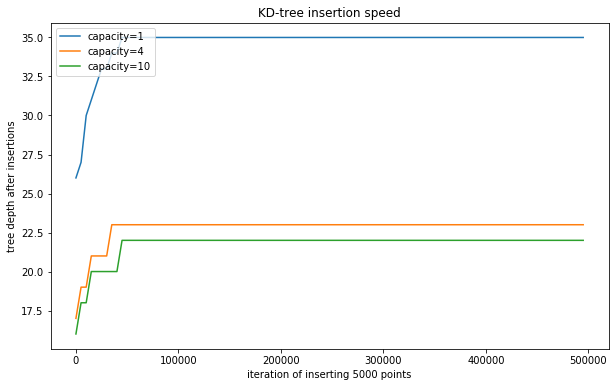

In [6]:
step = 5000
sample_size = 500000
trees = [
            Node(K=K_random), 
            Node(K=K_random), 
            Node(K=K_random)
]
capacities = [1, 4, 10]


sizes, depths = [], [[], [], []]
max_depth = [0, 0, 0]
for i in tqdm_notebook(range(0, sample_size, step)):
    for item in R[i:i+step]:
        for t in range(3):
            trees[t].kd_insert_with_split((item[0], "stub value test 1.C."), leaf_capacity=capacities[t])
            max_depth[t] = max(trees[t].kd_find_leaf(item[0]).depth, max_depth[t])
    sizes.append(i)
    for t in range(3):
        depths[t].append(max_depth[t])

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('iteration of inserting 5000 points')
a.set_ylabel('tree depth after insertions')
plt.plot(sizes, depths[0], label="capacity={}".format(capacities[0]))
plt.plot(sizes, depths[1], label="capacity={}".format(capacities[1]))
plt.plot(sizes, depths[2], label="capacity={}".format(capacities[2]))
plt.legend(loc="upper left")
plt.title("KD-tree insertion speed")
plt.show()

### 1.D. ANNS search ### 
This block tests `get_nn()` method, which performs approximate nearest neighbour search. Please, complete this method. After you run this block you will see how NN count influences search speed.

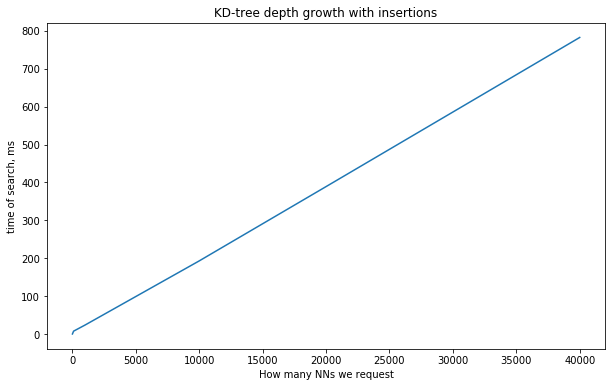

In [7]:
# NN SEARCH
kdtree = Node(K=K_random).build_kd_tree(R)
times = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm_notebook(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        kdtree.get_nn(x[0], nn)
    finish = time.time()
    times.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time of search, ms')
plt.title("KD-tree depth growth with insertions")
plt.plot(nns,times)
plt.show()

## 2. [Annoy](https://github.com/spotify/annoy) library ## 

Now you have your own index data structure. How far is it from industrial implementations?

First of all, let's install and import the requirement. Just run it.

In [8]:
!pip install --user annoy
from annoy import AnnoyIndex

In [9]:
# use Eiclidean distance for the index. Also multiple others allowed
index = AnnoyIndex(K_random, 'euclidean')

for i, row in enumerate(R):
    index.add_item(i, row[0])

index.build(10) # number of trees

# this code shows how to save the index. Loading is fast - it uses memory map (mmap) of file
# index.save('test2.ann')
# index = AnnoyIndex(dim, 'euclidean')
# u.load('test2.ann')

True

Second, let's run a test for KNN search. 

Is it much faster?

Is it assimpotically faster?

Annoy implementation is faster for all NNS, they are almost equal for small NNs, but on larger NNs our implementation is much slower. 

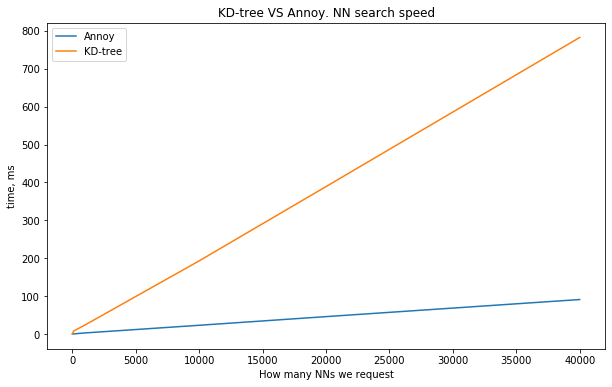

In [10]:
# NN SEARCH
times_annoy = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm_notebook(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        index.get_nns_by_vector(x[0], nn)
    finish = time.time()
    times_annoy.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time, ms')
plt.plot(nns, times_annoy, label='Annoy')
# you can also build times array on the same graph
plt.plot(nns, times, label='KD-tree')
plt.legend(loc="upper left")
plt.title("KD-tree VS Annoy. NN search speed")
plt.show()

## 3. Real data ##

Let's pracite on the real data. [Here are samples](https://drive.google.com/drive/folders/1nhiJC6g5R5uPDYwa-6sz9_bJ3sYGm8mM?usp=sharing) of GeoSite's database (63 countries, 21M POIs). Download and uncompress any dataset you like (or can), and load the data with pickle.

In [11]:
!unzip poi_sample_200K.zip

Archive:  poi_sample_200K.zip
replace poi_sample001.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


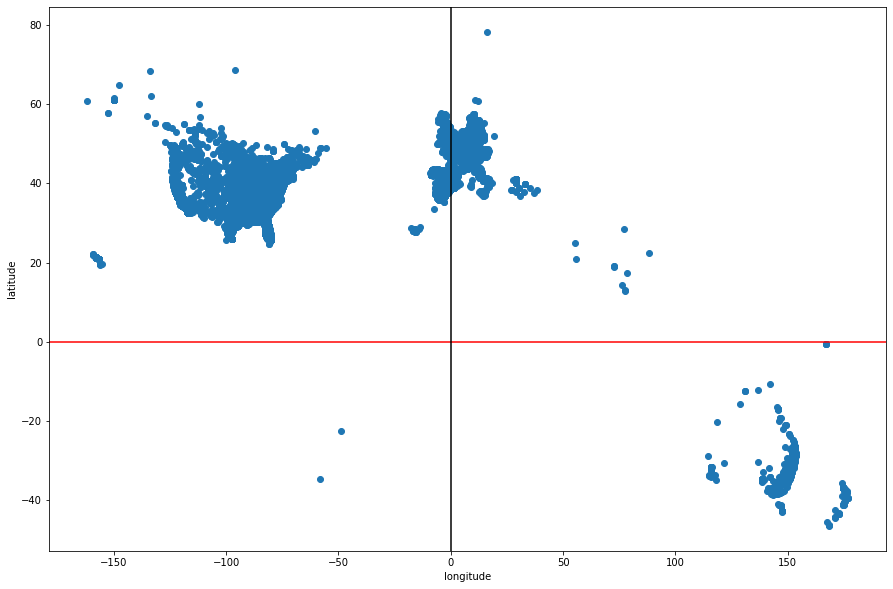

In [12]:
# replace filename if you want to use other index file
with open("poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000
    
X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

Now let's build the index on this real data. As it holds latitude and longutude, we will have `K=2`.

In [13]:
K_real = 2
start = time.time()
kdtree = Node(K=K_real).build_kd_tree(dataset)
finish = time.time()
print("Index build in {:.2f} sec.".format(finish - start))

Index build in 9.65 sec.


Check your nearest neighbours search works on real data.

In [14]:
paris = [2.334083, 48.853260]
boulder = [-105.205606, 40.063987]
sidney = [151.211122, -33.874236]

neigh = kdtree.get_nn(paris, 5000)
paris_nn = [v for v in kdtree.get_nn(paris, 5000) if 'Shop' in v[1]]
boulder_nn = [v for v in kdtree.get_nn(boulder, 5000) if "College" in v[1]]
sidney_nn = [v for v in kdtree.get_nn(sidney, 5000) if "Food" in v[1]]

# print to check that places you found are actually in neighbourhood
print("Australia, Sidney, food", sidney_nn[:5])

Australia, Sidney, food [([151.208053589, -33.8758888245], 'Health Plus, Food & Beverages, Specialty. AU, Sydney, Shop 10, 324 Pitt St'), ([151.205154419, -33.8717842102], 'Cabinet Corporate Hospitality The, Food & Beverages, Liquor & Beverages. AU, Sydney, 414 Kent St'), ([151.204437256, -33.8766212463], 'Uniliquor, Food & Beverages, Liquor & Beverages. AU, Sydney, 377 Sussex St'), ([151.202468872, -33.8838043213], "McDonald's Family Restaurants, Fast Food, . AU, Broadway, 863 George St"), ([151.223999023, -33.8751792908], 'Hunter Valley Food Services, Shopping, Stationery & Office Supplies. AU, Potts Point, 33 Bayswater Rd')]


Next block will draw your results on a map.

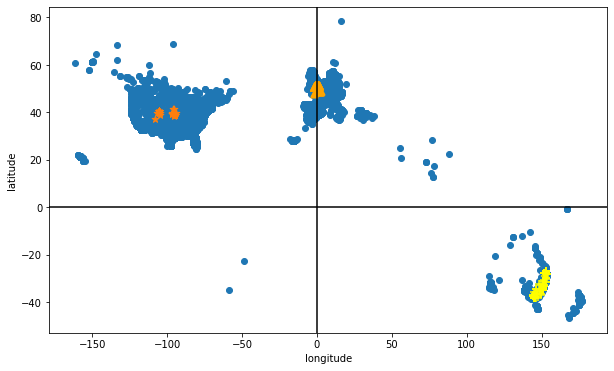

In [15]:
X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]
BX, BY = [v[0][0] for v in boulder_nn], [v[0][1] for v in boulder_nn]
PX, PY = [v[0][0] for v in paris_nn], [v[0][1] for v in paris_nn]
SX, SY = [v[0][0] for v in sidney_nn], [v[0][1] for v in sidney_nn]
plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.scatter(BX, BY, marker="*", s=50)
plt.scatter(PX, PY, marker="^", s=50, color="orange")
plt.scatter(SX, SY, marker="+", s=50, color='yellow')
plt.show()

## 3.B. Range search ##
Range search in kd-tree is based on the idea, that we skip branches that do not intersect search range. You can use comparison with `pivot` element to decide. Please write your code in `get_in_range()` method. It accepts 2 vector keys of lower-left and upper-right bounds.

Then run 2 following blocks to see if it works. At the map it should be a region on the East coast of US.

In [16]:
low, high = [-76.0, 38.0], [-72.0, 42.0]
region = kdtree.get_in_range(low, high) 
print("Found: {} items".format(len(region)))

Found: 15583 items


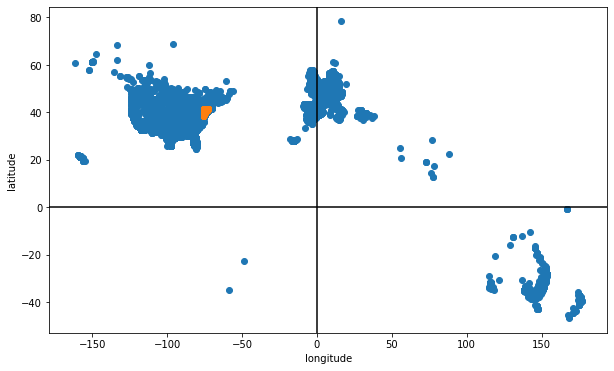

In [17]:
X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]
RX, RY = [v[0][0] for v in region], [v[0][1] for v in region]
plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.scatter(RX, RY, marker=".", s=50)
plt.show()

## 4. Bonus Task. Open questions ##
Change your code to answer:
1. How `K` parameter influences kd-tree search speed?
2. How `K` parameter influences Annoy search speed?
3. How branch split technique (pivot selection) influence tree depth?
4. How range size and `K` parameter influence range search in kd-tree?

Summarize your findings below.


In [0]:
def generate_data(k, maxsize=50000):
  R = np.random.rand(maxsize, k)
  return [(row, "stub value {}".format(i)) for i, row in enumerate(R)]

### 1. How K parameter influences kd-tree search speed?

On average K does not have tendency to increase the search time.

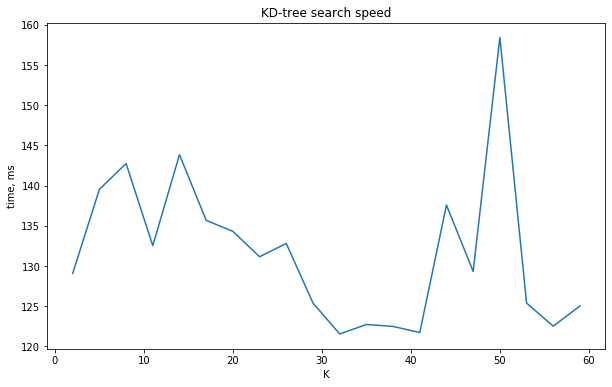

In [19]:
step = 3
sizes, build_times = [], []
iterations = 50
nn = 100

for K in tqdm_notebook(range(2, 60, step)):
    sample = generate_data(K)
    kdtree = Node(K=K).build_kd_tree(sample)
    start = time.time()
    # measure average search time for items
    for t in range(iterations):
      x = sample[t]
      kdtree.get_nn(x[0], nn)
    finish = time.time()
    sizes.append(K)
    build_times.append((finish - start) * 1000)

    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('K')
a.set_ylabel('time, ms')
plt.plot(sizes, build_times)
plt.title("KD-tree search speed")
plt.show()

### 2. How K parameter influences Annoy search speed?

As in case with kdtree, on average K does not have tendency to increase the search time.

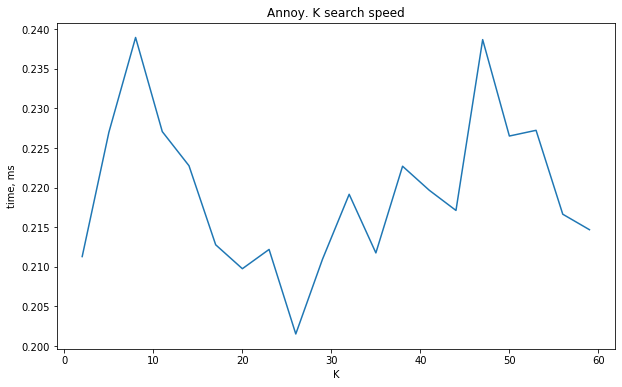

In [20]:
# NN SEARCH
sizes, times_annoy = [], []
iterations = 50
nn = 100

for K in tqdm_notebook(range(2, 60, step)):
    sample = generate_data(K)
    index = AnnoyIndex(K, 'euclidean')
    for i, row in enumerate(sample):
        index.add_item(i, row[0])
    index.build(10)

    start = time.time()
    # measure average search time
    for t in range(iterations):
      x = sample[t]
      index.get_nns_by_vector(x[0], nn)
    finish = time.time()
    sizes.append(K)
    times_annoy.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('K')
a.set_ylabel('time, ms')
plt.plot(sizes, times_annoy)
plt.title("Annoy. K search speed")
plt.show()

### 3. How branch split technique (pivot selection) influence tree depth?

In [21]:
# check kd tree depth and annoy trees depth for same data
def get_kd_depth(node):
  if node.items is not None:
    return [node.depth]
  else:
    return get_kd_depth(node.left)+get_kd_depth(node.right)

K=10
sample = generate_data(K)
kdtree = Node(K=K).build_kd_tree(sample)
depths = get_kd_depth(kdtree)
print(f'depth of kd tree {np.max(depths)}')

index = AnnoyIndex(K, 'euclidean')
for i, row in enumerate(sample):
    index.add_item(i, row[0])
index.build(5)

depth of kd tree 15


True

### 4. How range size and K parameter influence range search in kd-tree?

As for range size, as we increse the range the more time it takes to fine the neighbours, hence if the range is small in can not even look for some subtrees because of pivot value comparison.

The higher K we use the more time is required for range search.

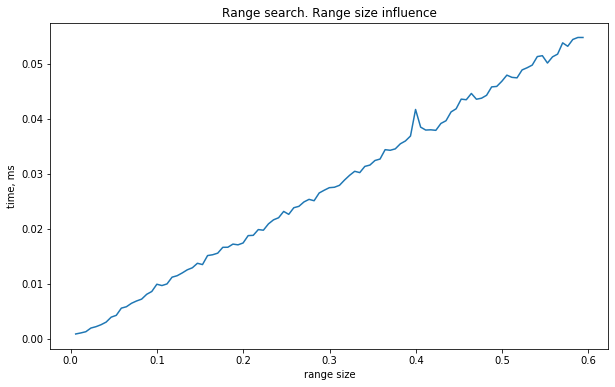

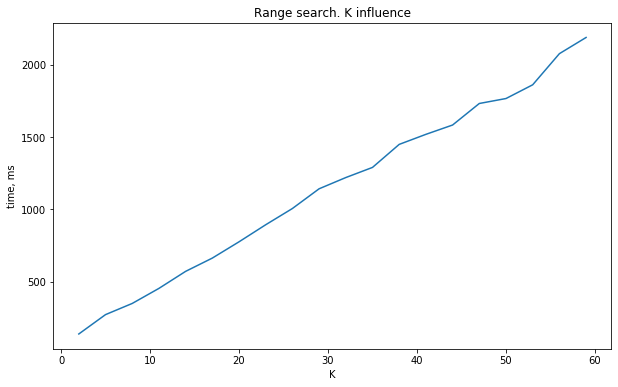

In [22]:
# first for range size in 1d case
K=1
sample = generate_data(K)
kdtree = Node(K=K).build_kd_tree(sample)
# find lower and higher in the data
low, high = 100, -100
for s in sample:
  if s[0][0]<low:
    low = s[0][0]
  elif s[0][0]>low: 
    high = s[0][0]
step = (high-low)/100
range_size, times = [], []
start_range = low
while start_range<=high:
  start_range+=step
  start = time.time()
  region = kdtree.get_in_range([low], [start_range]) 
  finish = time.time()
  range_size.append(start_range-low)
  times.append(finish-start)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('range size')
a.set_ylabel('time, ms')
plt.plot(range_size, times)
plt.title("Range search. Range size influence")
plt.show()

# then for K parameter
step = 3
sizes, times = [], []
for K in tqdm_notebook(range(2, 60, step)):
    sample = generate_data(K)
    kdtree = Node(K=K).build_kd_tree(sample)
    low, high = np.zeros(K)+100, np.zeros(K)-100
    for s in sample:
      for i in range(K):
        if s[0][i]<low[i]:
          low[i] = s[0][i]
        elif s[0][i]>high[i]:
          high[i] = s[0][i]
    start = time.time()
    # measure average search time for items
    region = kdtree.get_in_range(low, high)
    finish = time.time()
    sizes.append(K)
    times.append((finish - start) * 1000)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('K')
a.set_ylabel('time, ms')
plt.plot(sizes, times)
plt.title("Range search. K influence")
plt.show()